In [1]:
from strategies.alphas import * 
import yfinance as yf

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import importlib

def prepData(data):
    tickers = []
    alphas_selected = [12,102]

    # alpha_function_names = ["alpha"+str(x) for x in range(1,102)]
    alpha_function_names = ["alpha"+str(x) for x in alphas_selected]
    print(alpha_function_names)
    alpha_functions = {}
    failed_alphas = []

    for alpha_name in alpha_function_names:

        try:
            # print(f"for {alpha_name}\n")

            module = importlib.import_module("strategies.alphas")
            alpha_function = getattr(module, alpha_name)
            alpha_functions[alpha_name] = alpha_function

            data[alpha_name] = alpha_function(data)
            

            
        except Exception as ex:
            failed_alphas.append(alpha_name)
    
    return data

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_score
from strategies.alphas import *


def compute_labels(data, x_pct, n_days):
    labels = []
    for index, row in data.iterrows():
        row_index = data.index.get_loc(index)  # Get the integer index
        future_prices = data['Close'].iloc[row_index + 1:row_index + n_days + 1]
        price_change = (future_prices / row['Close']) - 1
        if any(price_change >= x_pct):
            labels.append(1)  # Price went up by x_pct or more within next n days
        else:
            labels.append(0)  # Price didn't go up by x_pct within next n days
    return labels

def train_random_forest(data,data_test):
    # Replace X and y with your actual dataset

    data = prepData(data)
    print(len(data))
    y = compute_labels(data, 0.03, 3)

    data=data.drop(["Close","Open","Volume",'High', 'Low', 'Adj Close','returns'],axis =1 )
    # print("this is being trained upon",data)

    data_test = prepData(data_test)
    y_test = compute_labels(data_test,0.03,3)
    data_test=data_test.drop(["Close","Open","Volume",'High', 'Low', 'Adj Close','returns'],axis =1 )



    # Split the dataset into training and testing sets

    # Initialize the random forest classifier
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=43)

    # Train the random forest classifier
    rf_classifier.fit(data, y)

    # Make predictions on the test set
    y_pred = rf_classifier.predict(data_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precsion = precision_score(y_test, y_pred)

    print("Accuracy:", accuracy)
    print("Precsion:", precsion)

    return rf_classifier,[y_pred,y_test]

In [5]:
from sklearn.neural_network import MLPClassifier

def train_neural_network(data, data_test):
    # Preprocess the data (replace with your preprocessing steps)
    data = prepData(data)
    data_test = prepData(data_test)
    data = data.dropna()
    data_test = data_test.dropna()
    
    # Compute labels
    y = compute_labels(data, 0.03, 3)
    y_test = compute_labels(data_test, 0.03, 3)
    
    # Drop unnecessary columns
    drop_columns = ["Close", "Open", "Volume", 'High', 'Low', 'Adj Close']
    data = data.drop(drop_columns, axis=1)
    data_test = data_test.drop(drop_columns, axis=1)
    
    # Initialize the MLP classifier
    mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', random_state=43)
    
    # Train the MLP classifier
    mlp_classifier.fit(data, y)
    
    # Make predictions on the test set
    y_pred = mlp_classifier.predict(data_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precsion = precision_score(y_test, y_pred)

    print("Accuracy:", accuracy)
    print("Precsion:", precsion)
    
    return mlp_classifier, [y_pred, y_test]


In [6]:
train_data = yf.download("itc.ns",'2022-01-01','2023-08-08')
test_data= yf.download("itc.ns", start = '2023-08-01',end='2024-02-22')

rf,lis = train_neural_network(train_data,test_data)
# rf,lis = train_random_forest(train_data,test_data)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
['alpha12', 'alpha102']
['alpha12', 'alpha102']
Accuracy: 0.9635036496350365
Precsion: 0.0


/home/dhruv/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dhruv/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<AxesSubplot:>

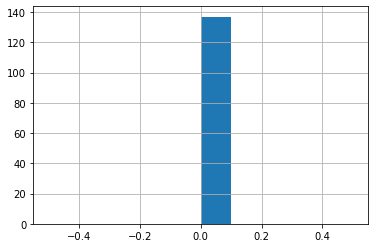

In [7]:
pd.Series(lis[0]).hist()


<AxesSubplot:>

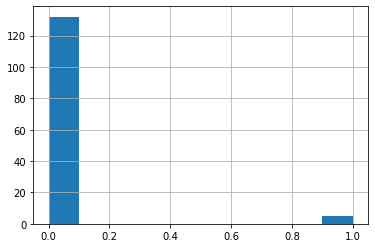

In [8]:
pd.Series(lis[1]).hist()

In [9]:
results=pd.DataFrame( [lis[1]] )

results = results.transpose()
results["Date"] = test_data.index
results[results[0] == 1]

ValueError: Length of values (138) does not match length of index (137)

In [ ]:
from utils.ga_utils import *
import warnings
from utils.optimizer import *
from utils.data_utils import * 
from utils.train_rf import *


def evaluate_strategy_test(data,rf_model,*args):
    data = data.copy()  # Make a copy of the data to avoid modifying the original DataFrame
    # data['alpha'] = alpha_fun(data, *args[:-2])  # Assuming you still want to compute alpha
    # data['alpha102'] = alpha102(data,2,10)
    stop_loss_percentage = args[-1]
    # print(f"paramters passed to the random forest{args[:-2]}")
    alpdata  = prepData(data)
    alpdata=alpdata.drop(["Close","Open","Volume",'High', 'Low', 'Adj Close'],axis =1 )



    position = 0  # 0 for no position, 1 for long position
    profit = 0
    total_trades = 0
    winning_trades = 0
    stricly_winning_trades = 0
    allocated_funds = 100000
    returns = []



    for i in range(1, len(data)):
        try:
            if position == 0:
                # Predict using the random forest model
                if rf_model.predict([alpdata.iloc[i]])[0] == 1:  # If model predicts 1, enter long position
                    position = 1
                    entry_price = data['Close'][i]
                    stop_loss_price = entry_price - (entry_price * 0.01 * stop_loss_percentage)
                    print(f"Entry: {entry_price} on {data.index[i]} Stop Loss: {stop_loss_price}")

                    total_trades += 1
                    no_of_shares = allocated_funds // entry_price
            elif position == 1:
                if data['Close'][i] > entry_price:  # Adjust stop loss only when the price goes up
                    stop_loss_price = max(stop_loss_price, data['Close'][i] - (data['Close'][i] * 0.01 * stop_loss_percentage))
                    
                if data['Low'][i] < stop_loss_price :#:or data['alpha'][i] < threshold_exit:  # add condition for time based exit here
                    position = 0  # Sell due to stop loss
                    exit_price = data['Open'][i] if stop_loss_price > data['Open'][i] else stop_loss_price
                    no_of_shares = allocated_funds//entry_price
                    trade_profit = (exit_price - entry_price) * no_of_shares  # Calculate profit/loss
                    profit=trade_profit
                    allocated_funds += profit
                    return_on_trade = (exit_price -entry_price) * 100/entry_price
                    returns.append(return_on_trade)
                    print(f"Exit: {exit_price} on {data.index[i]} exited on stop loss Allocated Funds {allocated_funds}")
           
                    if(exit_price>= entry_price):
                        winning_trades += 1
                    if(exit_price> entry_price):
                        stricly_winning_trades += 1
            # Rest of the code remains unchanged

        except Exception as ex:
            print("Error occurred:", ex)
            break

    # Calculate and return metrics
    win_rate = winning_trades / total_trades if total_trades != 0 else 0
    metrics = {
        "Profit": profit,
        "Total Trades": total_trades,
        "Winning Trades": winning_trades,
        "Strictly Winning Trades": stricly_winning_trades,
        "Win Rate": win_rate,
        "Allocated Funds": allocated_funds,
        "Sharpe Ratio": calculate_sortino_ratio(pd.Series(returns))
    }
    
    return metrics





In [ ]:
evaluate_strategy_test(train_data,rf,1)

['alpha14', 'alpha102']
Error occurred: X has 3 features, but RandomForestClassifier is expecting 2 features as input.


/home/dhruv/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


{'Profit': 0,
 'Total Trades': 0,
 'Winning Trades': 0,
 'Strictly Winning Trades': 0,
 'Win Rate': 0,
 'Allocated Funds': 100000,
 'Sharpe Ratio': nan}